In [1]:
# Import packages.
import cvxpy as cp
import numpy as np
import math
from scipy.linalg import expm
import matplotlib.pyplot as plt
from cvxpylayers.torch import CvxpyLayer

# Configure the display settings
np.set_printoptions(edgeitems=30, linewidth=125, 
    formatter=dict(float=lambda x: "%3.3f" % x))

In [2]:
# Parameter Initialization
# Background Parameter
g=[-3.7114, 0, 0]
pi = math.pi
m_dry=1505
m_wet=1905
I_sp=225
T1=930
T2=2480
n=6
phii=27*2*pi/360
alpha=5.09e-4
# alpha = cp.Parameter(name="alpha", shape=1, value=s5.09e-4)

In [3]:
# Optimal t_f and N
t_f=68
N=55
time_step=t_f/N
#Initial State
position_0=[3000, 1000, 2000]
velocity_0=[-50,10,100]
y0=np.array([position_0 + velocity_0 + [np.log(m_wet)]]).T
#print(y0, y0.shape)

In [4]:
# Define A_c Matrix
A_c1 = np.concatenate((np.zeros((3,3)), np.identity(3)), axis=1)
A_c2 = np.concatenate((A_c1, np.zeros((3,1))), axis=1)
A_c = np.concatenate((A_c2, np.zeros((4,7))), axis=0)
#print(A_c,A_c.shape)

In [5]:
# Define B_c Matrix
B_c1 = np.concatenate((np.zeros((3,3)), np.identity(3)),axis=0)
B_c2 = np.concatenate((B_c1, np.zeros((6,1))),axis=1)
B_c = np.concatenate((B_c2, np.array([[0,0,0,-alpha]])), axis=0)
#print(B_c,B_c.shape)

In [6]:
# Define A & B Matrix
"""
  Work on this later!!!
  
[A,B]=c2d(A_c,B_c,time_step);% A 7*7 ;B 7*4
"""
A = np.array([[1, 0, 0, 1.2364, 0, 0, 0],
              [0, 1, 0, 0, 1.2364, 0, 0],
              [0, 0, 1, 0, 0, 1.2364, 0],
              [0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 1]
    
])

alpha = 5.09e-4
B = np.array([[0.7643, 0, 0, 0],
              [0, 0.7643, 0, 0],
              [0, 0, 0.7643, 0],
              [1.2364, 0, 0, 0],
              [0, 1.2364, 0, 0],
              [0, 0, 1.2364, 0],
              [0, 0, 0, -alpha]
    
])
print("A=", A, A.shape)
print("B=", B, B.shape)
#print(A[:,0:3])

A= [[1.000 0.000 0.000 1.236 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 1.236 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000 1.236 0.000]
 [0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000]] (7, 7)
B= [[0.764 0.000 0.000 0.000]
 [0.000 0.764 0.000 0.000]
 [0.000 0.000 0.764 0.000]
 [1.236 0.000 0.000 0.000]
 [0.000 1.236 0.000 0.000]
 [0.000 0.000 1.236 0.000]
 [0.000 0.000 0.000 -0.001]] (7, 4)


In [7]:
# psi=np.zeros((7*N,4*N+4)) #psi 7N*(4N+4)
# psi[0:7,0:4]=B
# for k in range(2,N+1):
#     psi_next=A@psi[7*k-14:7*k-7,:]
#     psi[7*k-7:7*k,:]=psi_next
#     psi[7*k-7:7*k,4*k-4:4*k]=B
#     psi_next=psi[7*k-7:7*k,:]
# print(psi.shape)

In [8]:
psi = np.concatenate((B, np.zeros([7,N*4])),axis=1)
psi_prev = psi
for k in range(2,N+1):
    psi_next=A@psi_prev
    psi_next=np.concatenate((np.concatenate((psi_next[:,:4*(k-1)],B),axis=1),psi_next[:,4*(k-1)+4:]),axis=1)
    # psi_next[:-1,4*(k-1)-1] = 0 # clean up TODO: this is a hardcoded fix
    for i in range(k,1,-1):
        psi_next[:-1,4*(i-1)-1] = 0 # clean up TODO: this is a hardcoded fix
    psi = np.concatenate((psi, psi_next),axis=0)
    psi_prev = psi_next
print(psi.shape)

(385, 224)


In [9]:
# Matrix for State Computation  # A^k #(7*7N)
phi=np.zeros((7,7*N))
phi[:,0:7]=A
for k in range(2,N+1):
    phi[:,7*k-7:7*k]=A@phi[:,7*k-14:7*k-7]
print(phi.shape)

(7, 385)


In [10]:
# # lambda parameter
# lam=np.zeros((7,4*N)) #B+AB+......A^(k-1)B 7*4N
# lam[:,0:4]=B
# for k in range(2,N+1):
#     lam[:,4*k-4:4*k]=A@lam[:,4*k-8:4*k-4]+B
# print(lam.shape)

In [11]:
# lambda matrix  #B+AB+......A^(k-1)B  #(7*4N)
lam=B  
lam_prev=B
for k in range(2,N+1):
    # print("k",k)
    lam_next=A@lam_prev+B
    lam_next[:-1,-1] = 0 # clean up
    lam = np.concatenate([lam, lam_next], axis=1)
    lam_prev = lam_next
lam.shape

(7, 220)

In [12]:
# upsilon matrix      #(4N*(4N+4))
upsilon=np.zeros((4*N,4*N+4)) 
for k in range(1,N+1):
    upsilon[4*k-4:4*k,4*k-4:4*k]=np.identity(4)
print(upsilon.shape)

(220, 224)


In [13]:
# # Matrix for Optimal Computation
# Z0 = np.zeros((N+1,1))
# for k in range(N+1):
#     Z0[k,0]=np.log(m_wet-alpha*n*T2*math.cos(phii)*time_step*k) #(N+1)*1
# print(Z0.shape)

In [14]:
# Matrix for Optimal Computation 
k = 0
x = m_wet-alpha*n*T2*math.cos(phii)*time_step*k
a = 1e5
Z0 = np.array(a*x**(1/a) - a, ndmin=2)

for k in range(1,N+1):
    x = m_wet-alpha*n*T2*math.cos(phii)*time_step*k
    Z0_new = np.array(a*x**(1/a) - a, ndmin=2)
    Z0 = np.concatenate((Z0, Z0_new), axis=0)
print(Z0.shape)

(56, 1)


In [15]:
# mu_1 = np.zeros((1,N+1))
# mu_2 = np.zeros((1,N+1))
# for k in range(N+1):
#     mu_1[0,k]=n*T1*math.cos(phii)*np.exp(-Z0[k,0]) #1*(N+1)
#     mu_2[0,k]=n*T2*math.cos(phii)*np.exp(-Z0[k,0]) #1*(N+1)
# #print(mu_1, mu_1.shape)
# #print(mu_2, mu_2.shape)   

In [16]:
# Matrix for Optimal Computation 
mu_1 = np.array(n*T1*math.cos(phii)*cp.exp(-Z0[0,0]), ndmin = 2)  #(1*(N+1))
mu_2 = np.array(n*T2*math.cos(phii)*cp.exp(-Z0[0,0]), ndmin = 2)  #(1*(N+1))

for k in range(1, N+1):
    mu_1_new = np.array(n*T1*math.cos(phii)*cp.exp(-Z0[k,0]), ndmin = 2)
    mu_2_new = np.array(n*T2*math.cos(phii)*cp.exp(-Z0[k,0]), ndmin = 2)
    mu_1 = np.concatenate((mu_1, mu_1_new), axis = 1)
    mu_2 = np.concatenate((mu_2, mu_2_new), axis = 1)

In [17]:
# epsilon_k=np.zeros((7,N))
# for k in range(0,N):
#     temp = phi[:,7*k:7*(k+1)]@y0+lam[:,4*k:4*(k+1)]@np.array([g + [0]]).T
#     epsilon_k[:,k]=temp[:,0]
# print(epsilon_k.shape)

In [18]:
epsilon_k = phi[:,7*0:7*(0+1)]@y0+lam[:,4*0:4*(0+1)]@np.array([g + [0]]).T  #(7,1)
for k in range(1,N):
    temp = phi[:,7*k:7*(k+1)]@y0+lam[:,4*k:4*(k+1)]@np.array([g + [0]]).T
    epsilon_k = np.concatenate((epsilon_k, temp), axis = 1)
print(epsilon_k.shape)

(7, 55)


In [19]:
e_sigma = np.array([0,0,0,1])
#E = np.concatenate((np.identity(6), np.zeros((6,1))), axis=1)
F = np.concatenate((np.zeros(6), np.ones(1)), axis=None).reshape((1,7))
E_u = np.concatenate((np.identity(3), np.zeros((3,1))), axis=1)
print(F.shape)

(1, 7)


In [20]:
omega=np.zeros((1,4*N))  #1*4N
for k in range(0,N):
    omega[0,4*k:4*(k+1)]=e_sigma
omega=time_step*omega
print(omega.shape)

(1, 220)


In [21]:
# Define and solve the CVXPY problem.
eta = cp.Variable((4*N+4,1))
obj = cp.Minimize(omega@eta[0:4*N,0])


In [22]:
# Convexified Thrust Constraint
Conv_const = [
      cp.SOC(e_sigma@upsilon[4*k:4*k+4,:]@eta, E_u@upsilon[4*k:4*k+4,:]@eta) for k in range(N)
]

In [23]:
def multiply(X, Y):
    result = np.zeros((X.shape[0], Y.shape[1]))
    result = result.tolist()
    #print(f'a = {result}')
    # iterate through rows of X
    for i in range(X.shape[0]):
        # iterate through columns of Y
        for j in range(Y.shape[1]):
            # iterate through rows of Y
            for k in range(Y.shape[0]):
                result[i][j] += X[i][k] * Y[k][j]
    '''
    a = [[0]*mat2.shape[1]] * mat1.shape[0]
    for i in range(mat1.shape[0]):
        for j in range(mat2.shape[1]):
            for k in range(mat2.shape[0]):
                a[i][j] += mat1[i][k] * mat2[k][j]
    a = np.array(a)
    '''
    return np.array(result)

In [24]:
def list_dot_product(v1, v2):
    v3 = 0
    for i in range(len(v1)):
        v3 += v1[i] * v2[i]
    return v3

In [25]:
# #  Final velocity constraint
# v_const = [
#     np.array([[0, 0, 0, 1, 0, 0, 0]])@(epsilon_k[:,N-1].reshape((7,1))+psi[7*N-7:7*N,:]@eta)==0,
#     np.array([[0, 0, 0, 0, 1, 0, 0]])@(epsilon_k[:,N-1].reshape((7,1))+psi[7*N-7:7*N,:]@eta)==0,
#     np.array([[0, 0, 0, 0, 0, 1, 0]])@(epsilon_k[:,N-1].reshape((7,1))+psi[7*N-7:7*N,:]@eta)==0,
# ]

In [26]:
#  Final velocity constraint
a1 = np.expand_dims(epsilon_k[:,N-1],axis=1)
a2 = multiply(psi[7*N-7:7*N,:],eta)

v_const = [
    np.array([[0, 0, 0, 1, 0, 0, 0]])@cp.vstack((a1+a2).squeeze())==0,
    np.array([[0, 0, 0, 0, 1, 0, 0]])@cp.vstack((a1+a2).squeeze())==0,
    np.array([[0, 0, 0, 0, 0, 1, 0]])@cp.vstack((a1+a2).squeeze())==0,
]

In [27]:
#  Final height constraint
m1 = np.concatenate((np.identity(3), np.zeros((3,4))), axis=1)
m2 = np.concatenate((np.zeros((4,3)), np.zeros((4,4))), axis=1)
m = np.concatenate((m1, m2), axis=0)
h_const = [m@(epsilon_k[:,N-1].reshape((7,1))+psi[7*N-7:7*N,:]@eta)==np.zeros((7,1))]

In [28]:
# #  Final height constraint
# #h_const = [m@(epsilon_k[:,N-1]+psi[7*N-7:7*N,:]@eta) == np.zeros((7,1))]
# m1 = np.concatenate((np.identity(3), np.zeros((3,4))), axis=1)
# m2 = np.concatenate((np.zeros((4,3)), np.zeros((4,4))), axis=1)
# m = np.concatenate((m1, m2), axis=0)
# #print(f'm.shape = {m.shape}')
# a = multiply(psi[7*N-7:7*N,:],eta)
# #print(f'a.shape = {a.shape}')
# b = epsilon_k[:,N-1, np.newaxis]+a
# #print(f'b.shape = {b.shape}')
# c = multiply(m,b)
# #print(f'c.shape = {c.shape}')
# h_const = [i == 0 for i in c[:,0]]
# #print(h_const)

In [29]:
# thrust constraints
thr_const = [mu_1[0,0]*(1-(F@y0-Z0[0])+0.5*(F@y0-Z0[0])**2)<=e_sigma@upsilon[0:4,:]@eta,
            e_sigma@upsilon[0:4,:]@eta<=mu_2[0,0]*(1-(F@y0-Z0[0]))]
  
for k in range(0,N):
    thr_const.append(mu_1[0,k+1]*(1-(F.reshape((1,7))@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta)-Z0[k+1,0])+0.5*(F.reshape((1,7))@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta)-Z0[k+1,0])**2)<=e_sigma@upsilon[4*k:4*k+4,:]@eta)
    thr_const.append(e_sigma@upsilon[4*k:4*k+4,:]@eta<=mu_2[0,k+1]*(1-(F.reshape((1,7))@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta)-Z0[k+1,0])))


In [30]:
# # thrust constraints
# thr_const = [mu_1[0,0]*(1-(F@y0-Z0[0,0])+0.5*(F@y0-Z0[0,0])**2)<=e_sigma@upsilon[0:4,:]@eta,
#             e_sigma@upsilon[0:4,:]@eta<=mu_2[0,0]*(1-(F@y0-Z0[0,0]))]

# for k in range(0,N):
#     # print(f'thr_const for iter:{k}')
#     h3 = multiply(psi[7*k:7*(k+1),:],eta) # good
#     h1 = list_dot_product(F.squeeze(),(epsilon_k[:,k, np.newaxis]+h3)[:,0])-Z0[k+1,0]
#     h = 1-h1+0.5*(h1**2)
#     xLHS = mu_1[0,k+1]*h
#     xRHS = e_sigma@upsilon[4*k:4*k+4,:]@eta
#     thr_const.append(xLHS<=xRHS)

#     yLHS = e_sigma@upsilon[4*k:4*k+4,:]@eta
#     yRHS = mu_2[0,k+1]*(1-h1)
#     thr_const.append(yLHS <= yRHS)
    

In [31]:
# # Fuel mass constraints
# f_const = []
# for k in range(0,N):
#     f_const.append(F.reshape((1,7))@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta)<=np.log(m_wet-alpha*n*T1*math.cos(phii)*time_step*(k+1)))
#     f_const.append(np.log(m_wet-alpha*n*T2*math.cos(phii)*time_step*(k+1))<=F.reshape((1,7))@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta))


In [32]:
# Fuel mass constraints
f_const = []
for k in range(0,N):
    # print(f'f_const for iter:{k}')
    h3 = multiply(psi[7*k:7*(k+1),:],eta) # good
    h1 = list_dot_product(F.squeeze(),(epsilon_k[:,k, np.newaxis]+h3)[:,0])
    xLHS = h1
    xRHS = np.log(m_wet-alpha*n*T1*math.cos(phii)*time_step*(k+1))
    yLHS = np.log(m_wet-alpha*n*T2*math.cos(phii)*time_step*(k+1))
    yRHS = h1
    f_const.append(xLHS <= xRHS)
    f_const.append(yLHS <= yRHS)
    # f_const.append(0 <= yRHS)

In [33]:
# # Fuel mass constraints
# a = 1e5
# f_const = []
# for k in range(0,N):
#     # print(f'f_const for iter:{k}')
#     h3 = multiply(psi[7*k:7*(k+1),:],eta) # good
#     h1 = list_dot_product(F.squeeze(),(epsilon_k[:,k, np.newaxis]+h3)[:,0])
#     xLHS = h1
#     x = m_wet-alpha*n*T1*math.cos(phii)*time_step*(k+1)
#     xRHS = a*x**(1/a) - a
#     f_const.append(xLHS <= xRHS)
    
#     y = m_wet-alpha*n*T2*math.cos(phii)*time_step*(k+1)
#     yLHS = a*y**(1/a) - a
#     yRHS = h1
#     f_const.append(yLHS <= yRHS)
#     f_const.append(yRHS <= yLHS)

In [34]:
# Cone constraints
cone_const = [cp.norm(np.array([[0, 1, 0],[0, 0, 1]])@np.concatenate((np.identity(3),np.zeros((3,4))),axis=1)@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta),2)+np.array([[-0.268, 0, 0, 0, 0, 0, 0]])@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta)<=0]
cone_const

[Inequality(Expression(CONVEX, UNKNOWN, (1, 1)))]

In [35]:
# a1 = np.array([[0, 1, 0],[0, 0, 1]])@np.concatenate((np.identity(3),np.zeros((3,4))),axis=1)
# a2 = np.expand_dims(epsilon_k[:,k],axis=1) + multiply(psi[7*(N-1):7*(N),:],eta)
# a3 = multiply(a1,a2).squeeze()
# a4 = cp.norm(cp.vstack(a3))
# b1=np.array([[-0.268, 0, 0, 0, 0, 0, 0]])
# b2=multiply(b1,a2) 
# b2 = b2.tolist()[0][0]
# cone_const = [(a4+b2) <= 0]
# cone_const

In [36]:
socp_constraints =  Conv_const + h_const + v_const + cone_const + thr_const + f_const 

prob = cp.Problem(obj, socp_constraints)
print(prob.parameters())
prob.solve()
print(obj.value)
print(prob.status)
print("Problem is dpp:",prob.is_dpp())
print("Problem is dcp:",prob.is_dcp())

[]
421.4624430210132
optimal
Problem is dpp: True
Problem is dcp: True


In [37]:
#     Output Information
# Converting output into manageable format
display_position = np.zeros((3,N+1))
display_velocity = np.zeros((3,N+1))
display_netthrust = np.zeros((3,N+1))
display_thrust = np.zeros((3,N+1))
display_allthrust = np.zeros((1,N+1))
display_allvelocity = np.zeros((1,N+1))
display_position[0:3, 0] = position_0
display_velocity[0:3, 0] = velocity_0
mass = np.zeros((1,N+1))
mass[0] = m_wet

In [38]:
for k in range(0,N):
    v = (epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta.value)
    display_position[:,k+1] = (np.concatenate((np.identity(3), np.zeros((3,4))), axis=1)@v).reshape((3,))
    temp = np.concatenate((np.zeros((3,3)), np.identity(3)), axis=1)
    display_velocity[:,k+1] = (np.concatenate((temp, np.zeros((3,1))), axis=1)@v).reshape(3,)
    mass[0,k+1] = np.array([[0, 0, 0, 0, 0, 0, 1]])@v
    mass[0,k+1] = np.exp(mass[0,k+1])

for k in range(0,N):
    display_netthrust[:,k+1] = (np.concatenate((np.identity(3), np.zeros((3,1))), axis=1)@(upsilon[4*k:4*k+4,:]@eta.value)).reshape(3,)
    display_thrust[:,k+1] = display_netthrust[:,k+1]
    display_netthrust[:,k+1] = display_netthrust[:,k+1]*mass[0,k+1]
    #display_allthrust[0,k+1] = cp.norm(display_thrust[0:3,k+1],2)*mass[0,k+1]
    #display_allvelocity[0,k+1] = cp.norm(display_velocity[0:3,k+1],2)


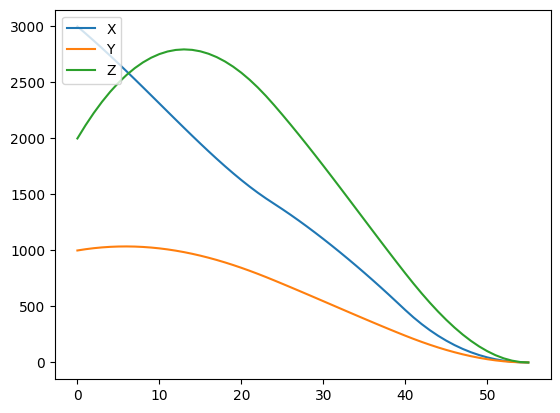

In [39]:
plt.plot(display_position[0,:],label="X")
plt.plot(display_position[1,:],label="Y")
plt.plot(display_position[2,:],label="Z")
plt.legend(loc="upper left")

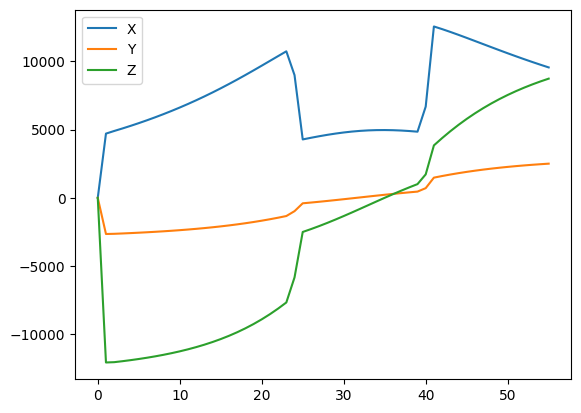

In [40]:
plt.plot(display_netthrust[0,:],label="X")
plt.plot(display_netthrust[1,:],label="Y")
plt.plot(display_netthrust[2,:],label="Z")
plt.legend(loc="upper left")

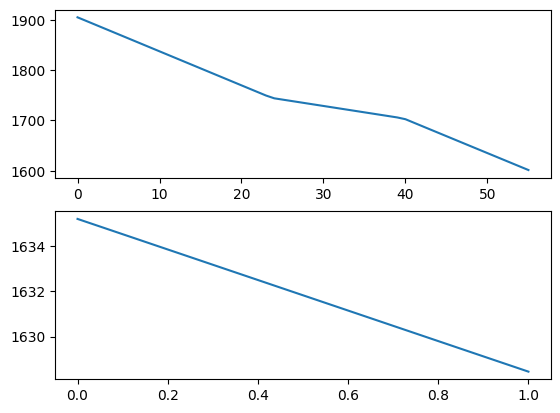

In [41]:
m1 = plt.subplot(2,1,1)
m2 = plt.subplot(2,1,2)
m1.plot(mass[0,:],label="Z")

m2.plot(mass[0,50:52],label="Z")